In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Set Chinese font support
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# Add project path
sys.path.append(os.path.dirname(os.path.abspath('')))

print("✓ Import completed")

✓ Import completed


In [2]:
# Import environment and configuration
from src.Environment import ChargingIntegratedEnvironment
from config.config_manager import ConfigManager

# Initialize environment
num_vehicles = 20
num_stations = 8

env = ChargingIntegratedEnvironment(
    num_vehicles=num_vehicles,
    num_stations=num_stations,
    random_seed=42,
    use_intense_requests=False
)

print(f"✓ Environment initialized: {num_vehicles} vehicles, {num_stations} charging stations")
print(f"✓ Grid size: {env.grid_size}x{env.grid_size}")

Using fallback logging instead of TensorBoard to avoid protobuf compatibility issues
✅ 配置加载成功: c:\Users\miaoz\OneDrive\桌面\EV-ADP-1\config\config_adp.json
✓ Environment random seed set to 42
✓ Vehicles initialized with fixed seed 42 - consistent initial states
[(3, 3), (10, 3), (3, 10), (10, 10)]
✓ Initialized integrated environment: 20 vehicles, 8 charging stations
✓ Environment initialized: 20 vehicles, 8 charging stations
✓ Grid size: 15x15


## 1. Single Vehicle Charging Probability Curve

Analyze charging probability for one EV at different SOC levels

In [3]:
# Find an EV
ev_id = None
for vehicle_id, vehicle in env.vehicles.items():
    if vehicle['type'] == 1:  # EV
        ev_id = vehicle_id
        break

if ev_id is None:
    print("❌ No EV vehicle found")
else:
    print(f"✓ Found EV vehicle ID: {ev_id}")
    print(f"  Current location: {env.vehicles[ev_id]['location']}")
    print(f"  Current battery: {env.vehicles[ev_id]['battery']:.2%}")

✓ Found EV vehicle ID: 0
  Current location: 25
  Current battery: 51.13%


In [4]:
# Scan different SOC values and calculate charging probability
soc_values = np.linspace(0.05, 1.0, 50)  # SOC from 5% to 100%
charge_probs = []
station_prob_history = {}

# Save original battery level
original_battery = env.vehicles[ev_id]['battery']

for soc in soc_values:
    # Temporarily set vehicle battery
    env.vehicles[ev_id]['battery'] = soc
    
    # Calculate charging probability
    p_charge, station_probs = env.compute_ev_charge_probability(ev_id)
    charge_probs.append(p_charge)
    
    # Record probability for each charging station
    for station_id, prob in station_probs.items():
        if station_id not in station_prob_history:
            station_prob_history[station_id] = []
        station_prob_history[station_id].append(prob)

# Restore original battery level
env.vehicles[ev_id]['battery'] = original_battery

print(f"✓ Completed calculation for {len(soc_values)} SOC points")
print(f"  Charging probability range: {min(charge_probs):.2%} - {max(charge_probs):.2%}")

✓ Completed calculation for 50 SOC points
  Charging probability range: 0.27% - 99.99%


In [5]:
charge_probs

[0.9999296290946967,
 0.9999034776917332,
 0.9998676091290135,
 0.9998184139045942,
 0.9997509427428166,
 0.9996584101778524,
 0.999531514979257,
 0.9993575105249664,
 0.9991189343986644,
 0.9987918747076042,
 0.9983436087134304,
 0.997729395039745,
 0.9968881320488128,
 0.9957365116003716,
 0.9941612028978551,
 0.9920085076292655,
 0.9890708642433721,
 0.98506960660836,
 0.9796336158969171,
 0.9722741475113207,
 0.9623574945110803,
 0.9490797289673004,
 0.931452055872228,
 0.90831153972873,
 0.8783792111468048,
 0.8403923271675522,
 0.7933322484227868,
 0.7367431715207805,
 0.6710833243007189,
 0.5979831196893332,
 0.5202509256039067,
 0.4415257007550203,
 0.36563410772207067,
 0.2958761757859764,
 0.23450718646973628,
 0.1825666584517485,
 0.14002595502183926,
 0.10611110169117709,
 0.07964976320043747,
 0.05934907159512629,
 0.04397528293669076,
 0.03244655307213762,
 0.02386479236814149,
 0.01751173336187924,
 0.01282770029105197,
 0.009384583588633208,
 0.0068592213762389866,
 0.0

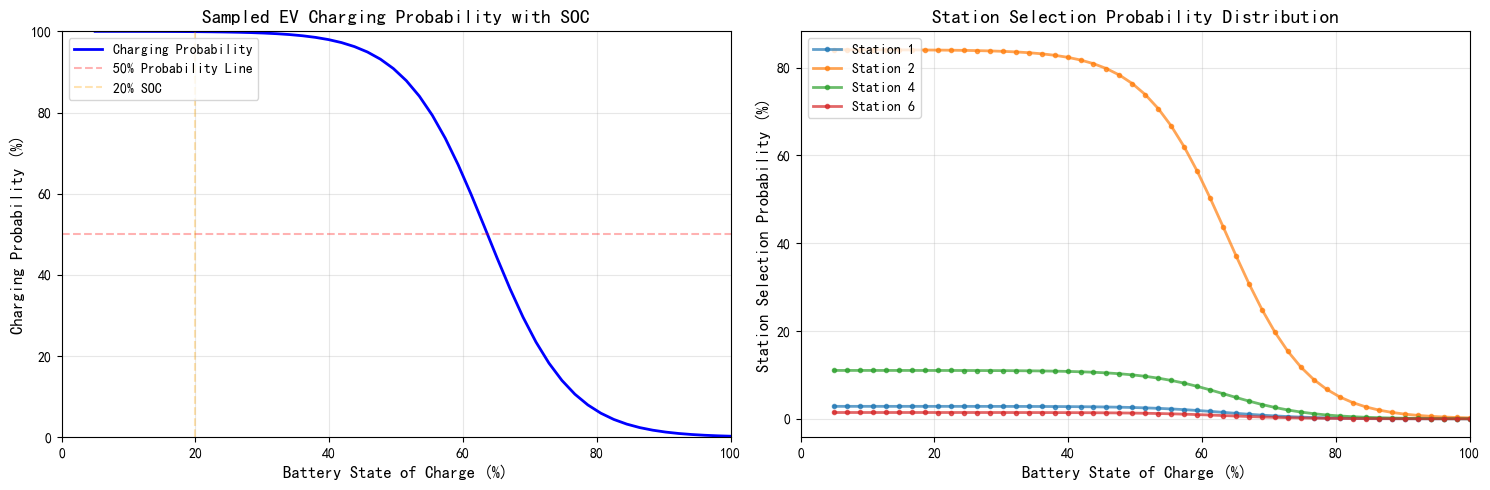

✓ Chart saved to results/charging_probability_vs_soc.png


In [6]:
# Plot charging probability vs SOC relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Charging probability curve
ax1.plot(soc_values * 100, np.array(charge_probs) * 100, 'b-', linewidth=2, label='Charging Probability')
ax1.axhline(y=50, color='r', linestyle='--', alpha=0.3, label='50% Probability Line')
ax1.axvline(x=20, color='orange', linestyle='--', alpha=0.3, label='20% SOC')
ax1.set_xlabel('Battery State of Charge (%)', fontsize=12)
ax1.set_ylabel('Charging Probability (%)', fontsize=12)
ax1.set_title(f'Sampled EV Charging Probability with SOC', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)

# Right plot: Station selection probability
for station_id, probs in station_prob_history.items():
    # Only show stations with significant probability
    if max(probs) > 0.01:  # Maximum probability exceeds 1%
        ax2.plot(soc_values * 100, np.array(probs) * 100, linewidth=2, label=f'Station {station_id}', marker='o', markersize=3, alpha=0.7)

ax2.set_xlabel('Battery State of Charge (%)', fontsize=12)
ax2.set_ylabel('Station Selection Probability (%)', fontsize=12)
ax2.set_title('Station Selection Probability Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('results/charging_probability_vs_soc.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved to results/charging_probability_vs_soc.png")

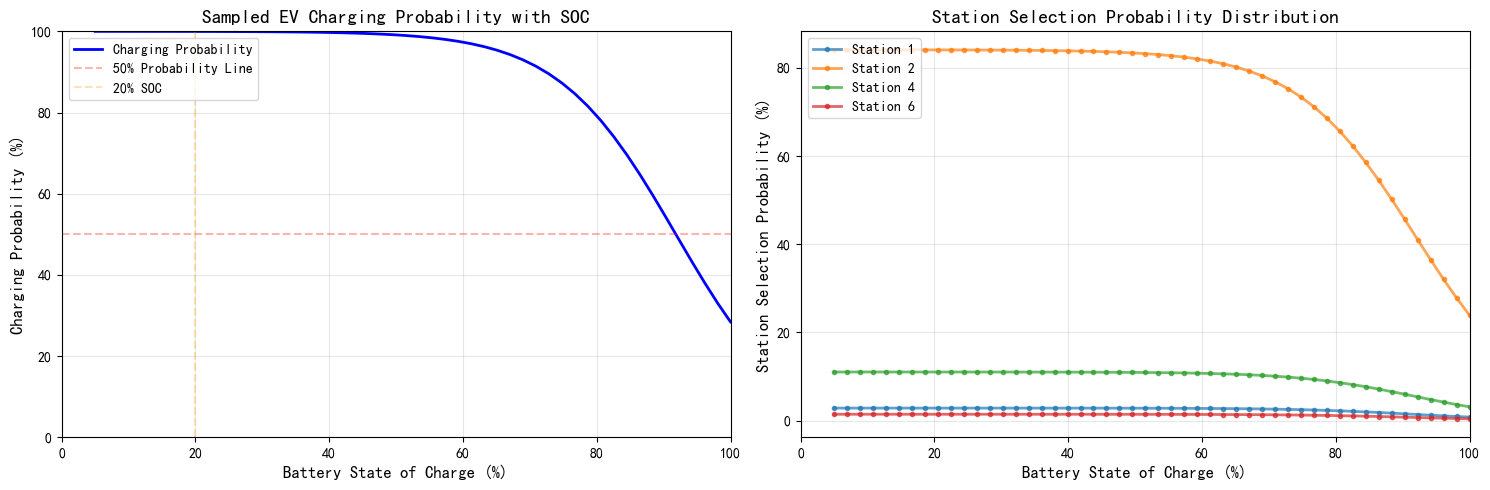

✓ Chart saved to results/charging_probability_vs_soc.png


In [6]:
# Plot charging probability vs SOC relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Charging probability curve
ax1.plot(soc_values * 100, np.array(charge_probs) * 100, 'b-', linewidth=2, label='Charging Probability')
ax1.axhline(y=50, color='r', linestyle='--', alpha=0.3, label='50% Probability Line')
ax1.axvline(x=20, color='orange', linestyle='--', alpha=0.3, label='20% SOC')
ax1.set_xlabel('Battery State of Charge (%)', fontsize=12)
ax1.set_ylabel('Charging Probability (%)', fontsize=12)
ax1.set_title(f'Sampled EV Charging Probability with SOC', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)

# Right plot: Station selection probability
for station_id, probs in station_prob_history.items():
    # Only show stations with significant probability
    if max(probs) > 0.01:  # Maximum probability exceeds 1%
        ax2.plot(soc_values * 100, np.array(probs) * 100, linewidth=2, label=f'Station {station_id}', marker='o', markersize=3, alpha=0.7)

ax2.set_xlabel('Battery State of Charge (%)', fontsize=12)
ax2.set_ylabel('Station Selection Probability (%)', fontsize=12)
ax2.set_title('Station Selection Probability Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('results/charging_probability_vs_soc.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved to results/charging_probability_vs_soc.png")

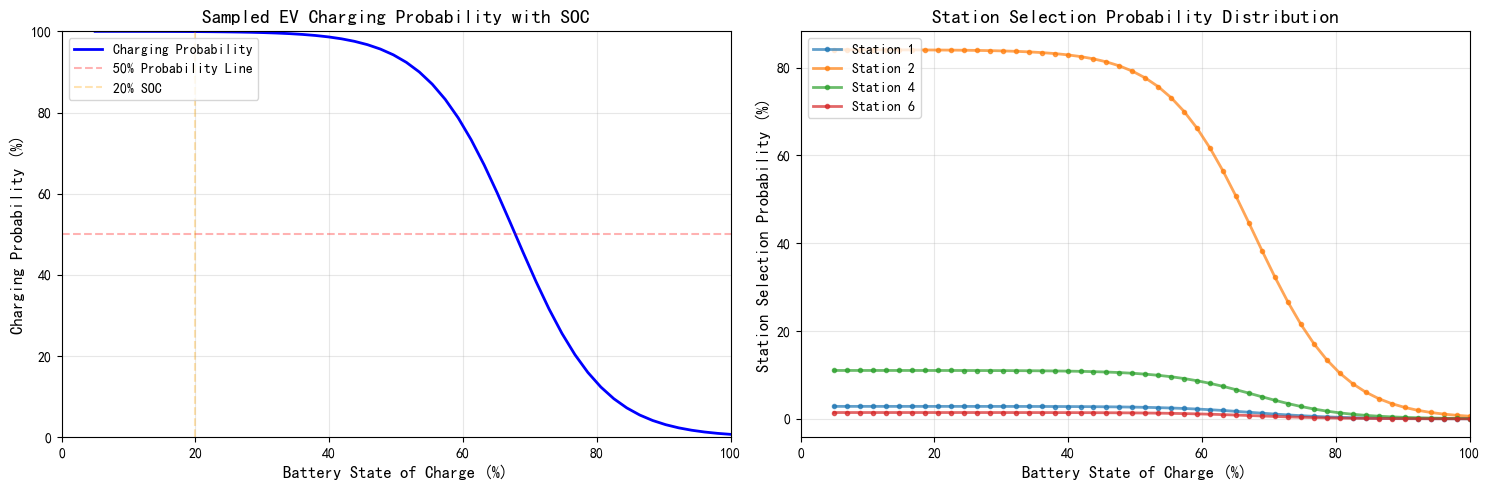

✓ Chart saved to results/charging_probability_vs_soc.png


In [6]:
# Plot charging probability vs SOC relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Charging probability curve
ax1.plot(soc_values * 100, np.array(charge_probs) * 100, 'b-', linewidth=2, label='Charging Probability')
ax1.axhline(y=50, color='r', linestyle='--', alpha=0.3, label='50% Probability Line')
ax1.axvline(x=20, color='orange', linestyle='--', alpha=0.3, label='20% SOC')
ax1.set_xlabel('Battery State of Charge (%)', fontsize=12)
ax1.set_ylabel('Charging Probability (%)', fontsize=12)
ax1.set_title(f'Sampled EV Charging Probability with SOC', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)

# Right plot: Station selection probability
for station_id, probs in station_prob_history.items():
    # Only show stations with significant probability
    if max(probs) > 0.01:  # Maximum probability exceeds 1%
        ax2.plot(soc_values * 100, np.array(probs) * 100, linewidth=2, label=f'Station {station_id}', marker='o', markersize=3, alpha=0.7)

ax2.set_xlabel('Battery State of Charge (%)', fontsize=12)
ax2.set_ylabel('Station Selection Probability (%)', fontsize=12)
ax2.set_title('Station Selection Probability Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('results/charging_probability_vs_soc.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved to results/charging_probability_vs_soc.png")

## 2. Key SOC Threshold Analysis

Identify SOC levels at which charging probability reaches specific values

In [13]:
# Create data table
df = pd.DataFrame({
    'SOC (%)': soc_values * 100,
    'Charging Probability (%)': np.array(charge_probs) * 100
})

# Find key thresholds
thresholds = [10, 25, 50, 75, 90]
threshold_socs = {}

for threshold in thresholds:
    # Find SOC closest to the threshold charging probability
    idx = np.argmin(np.abs(np.array(charge_probs) * 100 - threshold))
    threshold_socs[threshold] = soc_values[idx] * 100

# Display threshold table
threshold_df = pd.DataFrame([
    {'Charging Probability Threshold': f'{t}%', 'SOC Level': f'{threshold_socs[t]:.1f}%'}
    for t in thresholds
])

print("\n=== Key SOC Threshold Analysis ===")
print(threshold_df.to_string(index=False))

# Find the interval with fastest charging probability change
charge_prob_gradient = np.gradient(charge_probs, soc_values)
max_gradient_idx = np.argmax(np.abs(charge_prob_gradient))

print(f"\n📊 SOC interval with fastest charging probability change: {soc_values[max_gradient_idx]*100:.1f}%")
print(f"   Charging probability at this point: {charge_probs[max_gradient_idx]*100:.1f}%")


=== Key SOC Threshold Analysis ===
Charging Probability Threshold SOC Level
                           10%    100.0%
                           25%    100.0%
                           50%     92.2%
                           75%     82.6%
                           90%     72.9%

📊 SOC interval with fastest charging probability change: 92.2%
   Charging probability at this point: 48.8%


## 3. Multi-Vehicle Charging Probability Analysis

Compare charging probability curves for EV vehicles at different locations

Found 5 EV vehicles


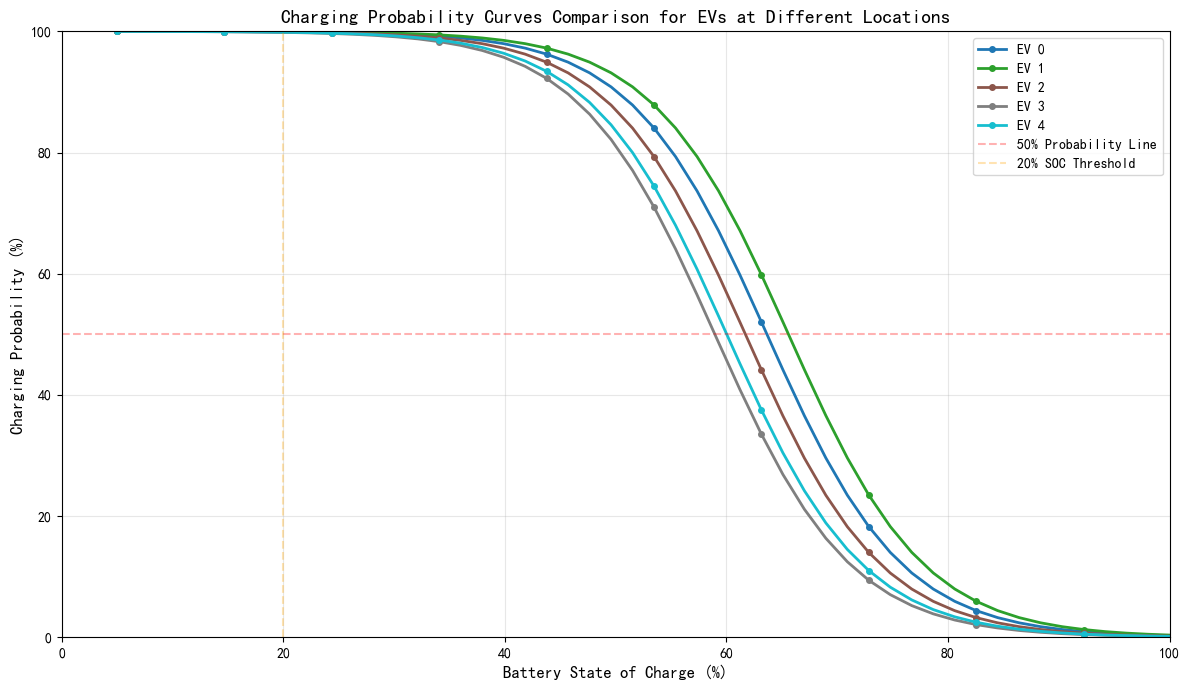

✓ Chart saved to results/multi_vehicle_charging_probability.png


In [7]:
# Collect all EV vehicles
ev_vehicles = [(vid, v) for vid, v in env.vehicles.items() if v['type'] == 1]

print(f"Found {len(ev_vehicles)} EV vehicles")

# Plot charging probability curves for first 5 EVs
fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.tab10(np.linspace(0, 1, min(5, len(ev_vehicles))))

for idx, (ev_id, vehicle) in enumerate(ev_vehicles[:5]):
    vehicle_probs = []
    original_battery = vehicle['battery']
    
    for soc in soc_values:
        env.vehicles[ev_id]['battery'] = soc
        p_charge, _ = env.compute_ev_charge_probability(ev_id)
        vehicle_probs.append(p_charge)
    
    env.vehicles[ev_id]['battery'] = original_battery
    
    ax.plot(soc_values * 100, np.array(vehicle_probs) * 100, 
            linewidth=2, color=colors[idx], label=f'EV {ev_id}',
            marker='o', markersize=4, markevery=5)

ax.axhline(y=50, color='red', linestyle='--', alpha=0.3, linewidth=1.5, label = '50% Probability Line')
ax.axvline(x=20, color='orange', linestyle='--', alpha=0.3, linewidth=1.5, label = '20% SOC Threshold')

ax.set_xlabel('Battery State of Charge (%)', fontsize=12)
ax.set_ylabel('Charging Probability (%)', fontsize=12)
ax.set_title('Charging Probability Curves Comparison for EVs at Different Locations', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('results/multi_vehicle_charging_probability.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved to results/multi_vehicle_charging_probability.png")

## 4. Charging Station Distance Impact Analysis

Analyze how vehicle-to-station distance affects charging probability


=== Station Distance vs Selection Probability Analysis (SOC=20%) ===
 Station ID  Distance (Manhattan)  Selection Probability (%)
          1                     4                  76.784081
          2                     7                  10.074398
          3                     7                  10.074398
          4                    10                   1.321804
          5                    10                   1.321804
          6                    13                   0.173426
          7                    13                   0.173426
          8                    16                   0.022754


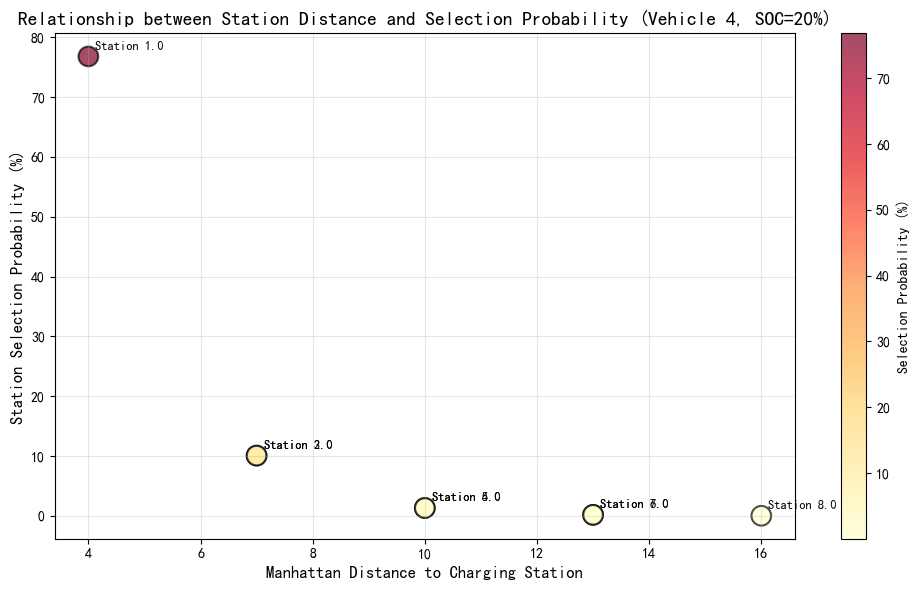

✓ Chart saved to results/distance_vs_probability.png


In [15]:
# Calculate distance from vehicle to each charging station
if ev_id is not None:
    vehicle_loc = env.vehicles[ev_id]['location']
    vehicle_x = vehicle_loc % env.grid_size
    vehicle_y = vehicle_loc // env.grid_size
    
    station_distances = {}
    for station_id, station in env.charging_manager.stations.items():
        station_x = station.location % env.grid_size
        station_y = station.location // env.grid_size
        distance = abs(vehicle_x - station_x) + abs(vehicle_y - station_y)
        station_distances[station_id] = distance
    
    # Analyze station selection at low SOC
    low_soc = 0.2
    env.vehicles[ev_id]['battery'] = low_soc
    _, station_probs = env.compute_ev_charge_probability(ev_id)
    env.vehicles[ev_id]['battery'] = original_battery
    
    # Create comparison data
    comparison_data = []
    for station_id in station_distances.keys():
        comparison_data.append({
            'Station ID': station_id,
            'Distance (Manhattan)': station_distances[station_id],
            'Selection Probability (%)': station_probs.get(station_id, 0) * 100
        })
    
    comparison_df = pd.DataFrame(comparison_data).sort_values('Distance (Manhattan)')
    
    print(f"\n=== Station Distance vs Selection Probability Analysis (SOC={low_soc*100:.0f}%) ===")
    print(comparison_df.to_string(index=False))
    
    # Plot distance vs probability scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    scatter = ax.scatter(comparison_df['Distance (Manhattan)'], comparison_df['Selection Probability (%)'], 
                        s=200, c=comparison_df['Selection Probability (%)'], cmap='YlOrRd', 
                        edgecolors='black', linewidth=1.5, alpha=0.7)
    
    # Add station ID labels
    for _, row in comparison_df.iterrows():
        ax.annotate(f"Station {row['Station ID']}", 
                   (row['Distance (Manhattan)'], row['Selection Probability (%)']),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax.set_xlabel('Manhattan Distance to Charging Station', fontsize=12)
    ax.set_ylabel('Station Selection Probability (%)', fontsize=12)
    ax.set_title(f'Relationship between Station Distance and Selection Probability (Vehicle {ev_id}, SOC={low_soc*100:.0f}%)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Selection Probability (%)')
    plt.tight_layout()
    plt.savefig('results/distance_vs_probability.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Chart saved to results/distance_vs_probability.png")

## 5. Charging Decision Heatmap

Visualize charging probability at different grid locations

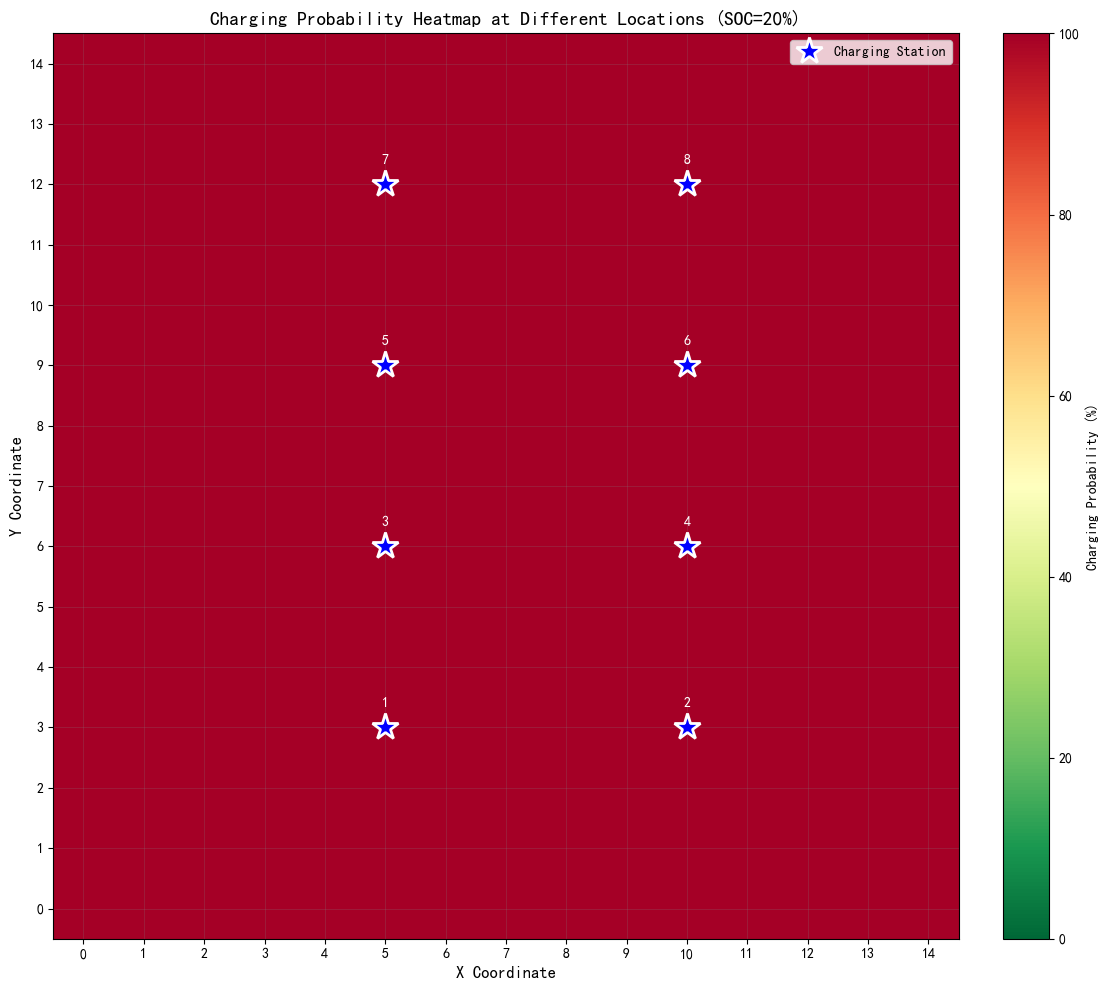

✓ Heatmap saved to results/charging_probability_heatmap.png

📊 Statistics:
   Average charging probability: 99.96%
   Maximum charging probability: 99.98%
   Minimum charging probability: 99.80%


In [16]:
# Create grid heatmap
grid_size = env.grid_size
test_soc = 0.2  # Test SOC = 20%

# Create charging probability grid
charge_prob_grid = np.zeros((grid_size, grid_size))

# Save original state
if ev_id is not None:
    original_location = env.vehicles[ev_id]['location']
    original_battery = env.vehicles[ev_id]['battery']
    
    # Scan all grid positions
    for x in range(grid_size):
        for y in range(grid_size):
            location = y * grid_size + x
            env.vehicles[ev_id]['location'] = location
            env.vehicles[ev_id]['coordinates'] = (x, y)
            env.vehicles[ev_id]['battery'] = test_soc
            
            p_charge, _ = env.compute_ev_charge_probability(ev_id)
            charge_prob_grid[y, x] = p_charge
    
    # Restore original state
    env.vehicles[ev_id]['location'] = original_location
    env.vehicles[ev_id]['coordinates'] = (original_location % grid_size, original_location // grid_size)
    env.vehicles[ev_id]['battery'] = original_battery
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    im = ax.imshow(charge_prob_grid * 100, cmap='RdYlGn_r', interpolation='nearest', 
                   vmin=0, vmax=100, origin='lower')
    
    # Mark charging station locations
    for station_id, station in env.charging_manager.stations.items():
        station_x = station.location % grid_size
        station_y = station.location // grid_size
        ax.plot(station_x, station_y, 'b*', markersize=20, markeredgecolor='white', 
               markeredgewidth=2, label=f'Charging Station' if station_id == list(env.charging_manager.stations.keys())[0] else '')
        ax.text(station_x, station_y + 0.3, f'{station_id}', ha='center', va='bottom', 
               fontsize=10, color='white', fontweight='bold')
    
    # Add grid lines
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    ax.set_title(f'Charging Probability Heatmap at Different Locations (SOC={test_soc*100:.0f}%)', 
                fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax, label='Charging Probability (%)', fraction=0.046, pad=0.04)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('results/charging_probability_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Heatmap saved to results/charging_probability_heatmap.png")
    print(f"\n📊 Statistics:")
    print(f"   Average charging probability: {np.mean(charge_prob_grid)*100:.2f}%")
    print(f"   Maximum charging probability: {np.max(charge_prob_grid)*100:.2f}%")
    print(f"   Minimum charging probability: {np.min(charge_prob_grid)*100:.2f}%")

## 6. Summary and Insights

Key findings and model characteristics

In [ ]:
print("="*60)
print("🎯 EV Charging Probability Model Analysis Summary")
print("="*60)

print("\n📊 Key Findings:")
print(f"1. Charging probability shows strong negative correlation with SOC")
print(f"2. Probability change is most significant in low SOC range")
print(f"3. Station selection is influenced by distance but not solely")
print(f"4. Charging probability varies across different locations")

print("\n🔍 Model Characteristics:")
print(f"- Uses Nested Logit model for charging decisions")
print(f"- Considers station distance, waiting time, and other factors")
print(f"- SOC is the primary driving factor")

print("\n💡 Application Recommendations:")
print(f"- Suggested charging threshold: 20-30% SOC")
print(f"- Station layout should consider high-demand areas")
print(f"- Dynamic charging strategy can improve efficiency")

print("\n" + "="*60)